<a href="https://colab.research.google.com/github/aishvellappally/Oil-Seep/blob/main/oil_seep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mounting google drive where the dataset is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Colab Tensorflow and Colab GPU runtime is used here
import sys
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.3.0
Found GPU at: /device:GPU:0


In [15]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) > 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
    print('multi-gpu')
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()
    print('single_gpu')

print("REPLICAS: ", strategy.num_replicas_in_sync)

single_gpu
REPLICAS:  1


In [53]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from keras import backend as K

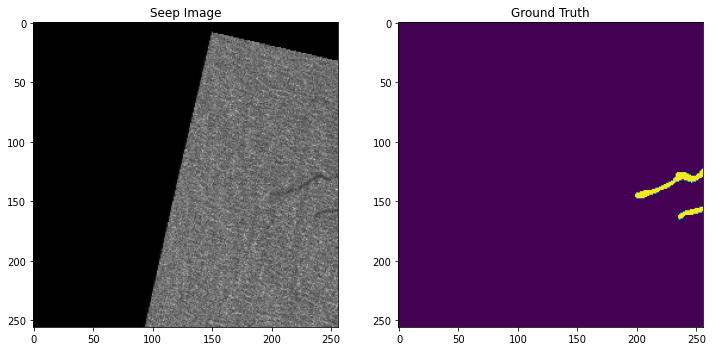

In [85]:
#Display a sample seep image and its mask
img = cv2.imread('/content/drive/My Drive/seep_detection/train_images_256/041869.000003.tif')
mask = plt.imread('/content/drive/My Drive/seep_detection/train_masks_256/041869.000003.tif')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
ax1.imshow(img)
ax1.set_title("Seep Image")
ax2.imshow(mask)
ax2.set_title("Ground Truth")
plt.show()

In [83]:
#folder containing true images
img_path = '/content/drive/My Drive/seep_detection/train_images_256/'

#folder containing mask images
masks_path = '/content/drive/My Drive/seep_detection/train_masks_256/'

#arrays to store images and masks respectively
images = []
masks = []

#parse through image and mask folders and store in images and masks array respectively
for figname in os.listdir(img_path):
  images.append(cv2.cvtColor(cv2.imread(img_path + figname), cv2.COLOR_BGR2RGB))
  masks.append(plt.imread(masks_path + figname))

#convert images to numpy array format
images = np.array(images)
masks = np.array(masks)

#Print shape of Image and Mask arrays
print(images.shape)
print(masks.shape)

(790, 256, 256, 3)
(790, 256, 256)


In [84]:
#Normalise pixels in image array by dividing by 255 so that pixel values range from 0-1
img_normal = (images / 255)

#Add one more axis to masks array to support image format
masks_process = (np.expand_dims(masks, -1) > 0).astype(np.float64)

#Split dataset into train,test and validation in the ration 8:1:1
X_train, X_test, y_train, y_test = train_test_split(img_normal, masks_process, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Print dataset shapes and sizes
print("Images Shape: ", img_normal.shape)
print("Masks Shape: ", masks_process.shape)

print("Training Samples: {}".format(len(y_train)))
print("Validation Samples: {}".format(len(y_val)))
print("Testing Samples: {}".format(len(y_test)))

Images Shape:  (790, 256, 256, 3)
Masks Shape:  (790, 256, 256, 1)
Training Samples: 632
Validation Samples: 79
Testing Samples: 79


In [86]:
#Defining model metrics 

#IOU coefficient - It is the Intersection over Union coefficient that evaluates the overlap ratio between the 
#ground truth and the predicted mask 
# IOU = Area of Intersection / Area of Union.
# An IOU of 0 means no overlap, that is predicted mask is not at all overlapping with ground truth
#IOU of 1 is perfect overlap
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

#DICE COEFFICIENT - The dice coefficient is like F1 score for image segmentation problem. It shows how many pixels
# in the image is predicted correctly at the right location as a ratio of the total number of pixels in both
# ground truth and predicted image. 
# Dice Coefficient = 2* Area of Overlap / Total Number of Pixels in both images
#The value ranges from 0 to 1, 0 for no overlap and 1 for perfect overlap
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#The above two metrics are useful as the images present a problem of imbalanced classification, where most pixels are
# not seep pixels. Hence the accuracy can be very high, even if theres no overlap, and this is misleading.

#Dice loss is 1-dice score
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
    
#Total loss is used as binary cross entropy plus dice loss
def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [88]:
#An Fully Convolutional Neural Network - FCNN is used here. It is a simple encoder-decoder architecture, which learns
# more features through convolution as it goes into the encoder, and uses transposed convolution (conv+upsample) to
# get predictions. This network is used to predict the mask, which can then be compared with ground truth.
#ADAM optimiser is used due to its adaptive learning rate feature.
with strategy.scope():
  
  inputs = Input((256, 256, 3))
  
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',padding = 'same') (inputs)
  
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',padding = 'same') (c1)

  m1 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',padding = 'same') (m1)

  u1 = UpSampling2D(size=(2, 2), interpolation='nearest') (c3)

  c4 = Conv2D(2, (5, 5), activation='relu', kernel_initializer='he_normal',padding = 'same') (u1)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c4)

  model = Model(inputs=[inputs], outputs=[outputs])
  
  opt  = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  
  model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou_coef,dice_coef, 'acc'])
  
  print(model.summary())


Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 128, 128, 16)      4624      
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 256, 256, 2)     

In [89]:
#Model training - early stopping is used if validation loss does not improve for 10 epochs in a row. Best model is 
#saved based on minimum validation loss. 
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-fcnn.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val,y_val),
                    callbacks=[earlystopper, checkpointer])


Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 1.1143 - iou_coef: 0.0119 - dice_coef: 0.0317 - acc: 0.9813
Epoch 00001: val_loss improved from inf to 1.04260, saving model to model-fcnn.h5
79/79 [==============================] - 3s 35ms/step - loss: 1.1143 - iou_coef: 0.0119 - dice_coef: 0.0317 - acc: 0.9813 - val_loss: 1.0426 - val_iou_coef: 0.0125 - val_dice_coef: 0.0407 - val_acc: 0.9817
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 1.0421 - iou_coef: 0.0136 - dice_coef: 0.0426 - acc: 0.9814
Epoch 00002: val_loss improved from 1.04260 to 1.04037, saving model to model-fcnn.h5
79/79 [==============================] - 2s 31ms/step - loss: 1.0421 - iou_coef: 0.0136 - dice_coef: 0.0426 - acc: 0.9814 - val_loss: 1.0404 - val_iou_coef: 0.0147 - val_dice_coef: 0.0465 - val_acc: 0.9817
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 1.0376 - iou_coef: 0.0149 - dice_coef: 0.0464 - acc: 0.9814
Epoch 00003: val_loss improved fr

In [74]:
#Model Prediction 
preds = model.predict(X_test)

In [69]:
def plot_preds(img, true, pred):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,8))
    
    ax1.imshow(img)
    ax1.set_title("Seep Image")

    ax2.imshow(true)
    ax2.set_title("Ground Truth")
    
    ax3.imshow(pred)
    ax3.set_title("Predicted Mask")

    plt.show()




Sample 0


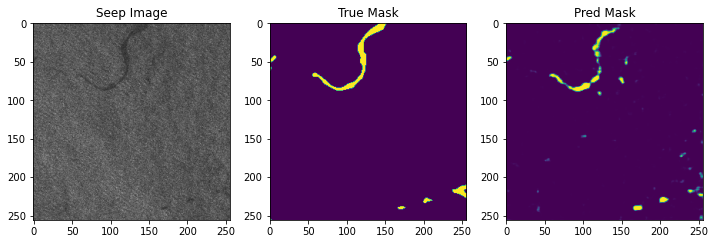




Sample 1


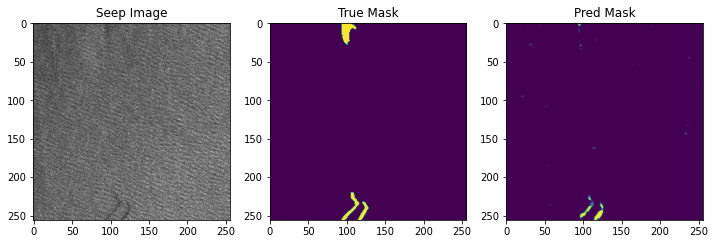




Sample 2


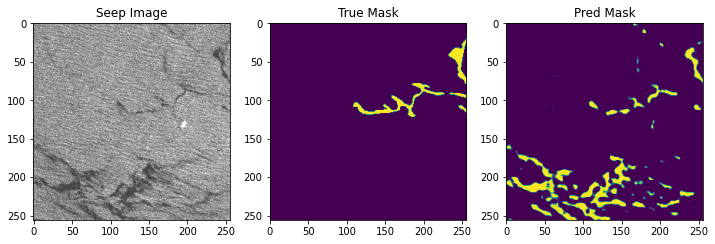




Sample 3


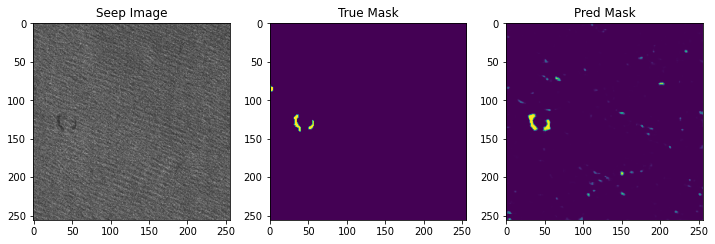




Sample 4


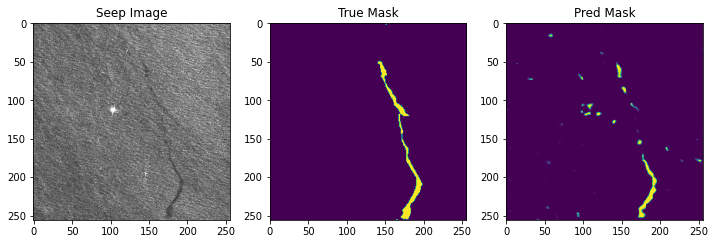




Sample 5


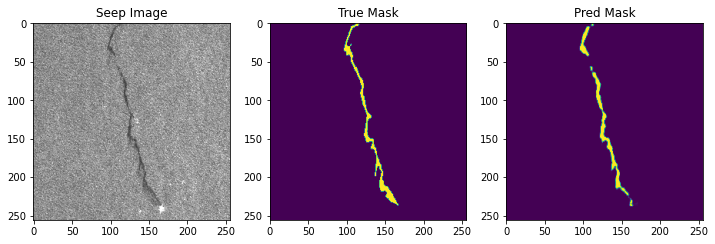




Sample 6


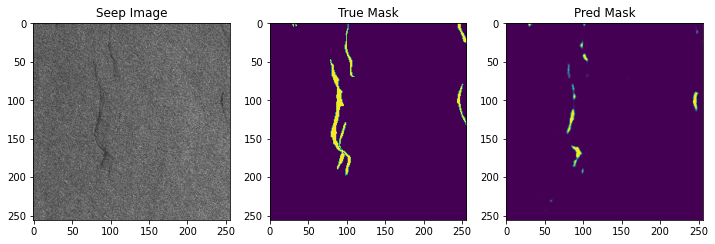




Sample 7


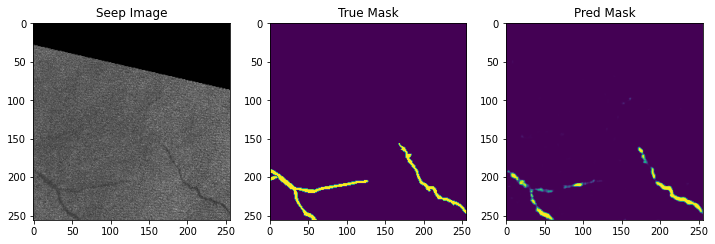




Sample 8


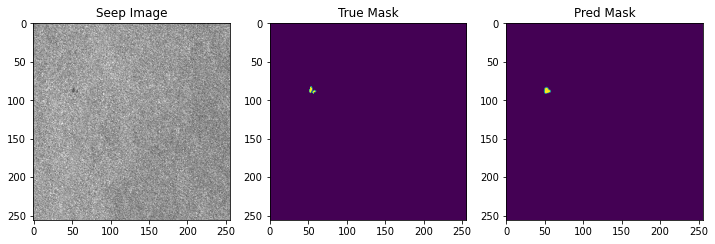




Sample 9


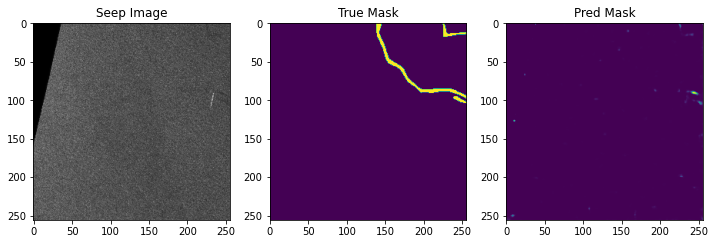




Sample 10


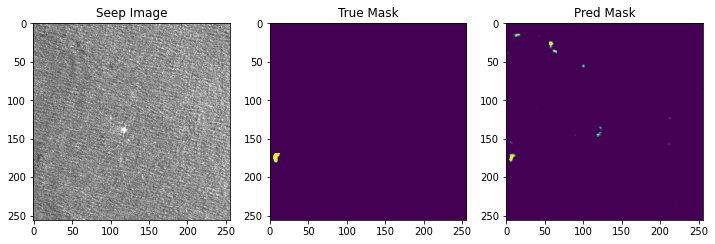




Sample 11


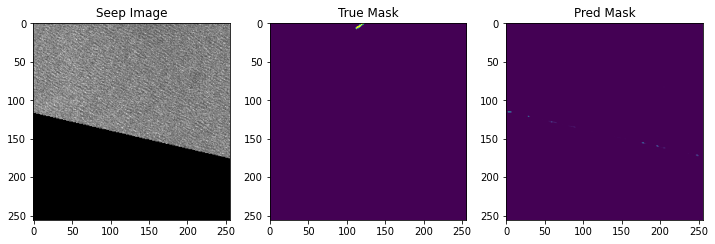




Sample 12


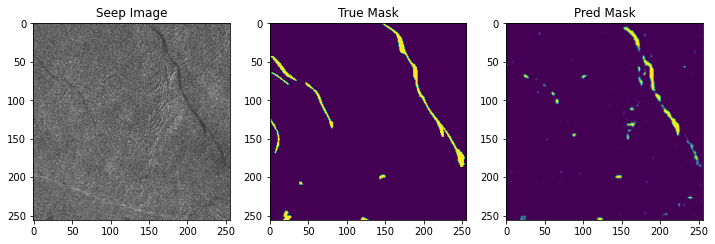




Sample 13


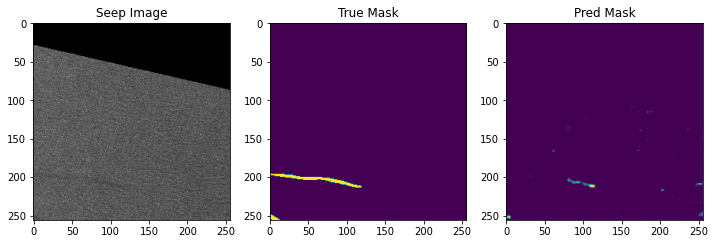




Sample 14


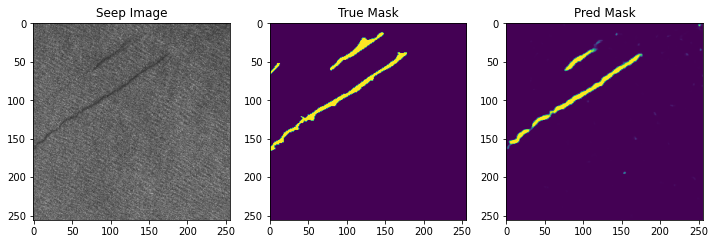

In [75]:
#Plot original image, ground truth and predictions for comparison
for i in range(10):
    print("\n\n Sample Image {}".format(i))
    plot_preds(X_test[i], y_test[i][:,:,0], preds[i][:,:,0])